In [1]:
#this will work for VTK output with rectilinear grid from pluto
import vtk
import numpy as np
import os


def read_vtk_file(file_name):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(file_name)
    reader.ReadAllScalarsOn()
    reader.Update()
    return reader.GetOutput()

def get_coordinate(grid, coord_type):
    if coord_type == 'X' and hasattr(grid, 'GetXCoordinates'):
        return np.array([grid.GetXCoordinates().GetValue(i) for i in range(grid.GetXCoordinates().GetNumberOfTuples())])
    elif coord_type == 'Y' and hasattr(grid, 'GetYCoordinates'):
        return np.array([grid.GetYCoordinates().GetValue(i) for i in range(grid.GetYCoordinates().GetNumberOfTuples())])
    elif coord_type == 'Z' and hasattr(grid, 'GetZCoordinates'):
        return np.array([grid.GetZCoordinates().GetValue(i) for i in range(grid.GetZCoordinates().GetNumberOfTuples())])
    else:
        return None

def vtk_to_numpy_manual(vtk_array):
    n_values = vtk_array.GetNumberOfTuples() * vtk_array.GetNumberOfComponents()
    values = [vtk_array.GetValue(i) for i in range(n_values)]
    return np.array(values)

def get_XCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'X')
    else:
        raise TypeError("Unsupported VTK data type for X coordinate extraction: {}".format(type(output).__name__))

def get_YCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'Y')
    else:
        raise TypeError("Unsupported VTK data type for Y coordinate extraction: {}".format(type(output).__name__))

def get_ZCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'Z')
    else:
        raise TypeError("Unsupported VTK data type for Z coordinate extraction: {}".format(type(output).__name__))

def get_FieldNames_pluto(file_name):
    output = read_vtk_file(file_name)
    variable_names = []
    if isinstance(output, vtk.vtkRectilinearGrid):
        cell_data = output.GetCellData()
        if cell_data:
            num_arrays = cell_data.GetNumberOfArrays()
            for i in range(num_arrays):
                array_name = cell_data.GetArrayName(i)
                if array_name:
                    variable_names.append(array_name)
    else:
        raise TypeError("Unsupported VTK data type for field name extraction: {}".format(type(output).__name__))
    return variable_names

def get_FieldValue(file_name, field_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        cell_data = output.GetCellData()
        if cell_data:
            array_data = cell_data.GetArray(field_name)
            if array_data:
                dims = [max(output.GetDimensions()[i] - 1, 1) for i in range(3)]
                np_data = vtk_to_numpy_manual(array_data).reshape(dims, order='F')
                return np_data
    else:
        raise TypeError("Unsupported VTK data type for field value extraction: {}".format(type(output).__name__))
    return None

def read_vtk_out(folder):
    vtk_info = {}
    vtk_out_path = os.path.join(folder, "vtk.out")
    with open(vtk_out_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            index = int(parts[0])
            time = float(parts[1])
            dt = float(parts[2])
            vtk_info[index] = {'time': time, 'dt': dt}
    return vtk_info

def get_time_and_dt(index, vtk_info):
    if index in vtk_info:
        return vtk_info[index]['time'], vtk_info[index]['dt']
    else:
        raise ValueError(f"No information found for index: {index}")

def get_time_and_dt_from_file_name(folder, file_name):
    vtk_info = read_vtk_out(folder)
    index_str = file_name.split('.')[1]
    index = int(index_str)
    if index in vtk_info:
        return vtk_info[index]['time'], vtk_info[index]['dt']
    else:
        raise ValueError(f"No information found for data file: {file_name}")

def process_vtk_file_by_number(folder, number):
    vtk_info = read_vtk_out(folder)
    data_file_name = f"data.{number:04d}.vtk"
    file_path = os.path.join(folder, data_file_name)
    
    print(f"Processing file: {file_path}")
    
    # Get time and dt
    time, dt = get_time_and_dt(number, vtk_info)
    print(f"Time: {time}, dt: {dt}")
    
    # Get X, Y, Z coordinates
    x_coord = get_XCoordinate_pluto(file_path)
    y_coord = get_YCoordinate_pluto(file_path)
    z_coord = get_ZCoordinate_pluto(file_path)
    
    print("X Coordinate:", x_coord)
    print("Y Coordinate:", y_coord)
    print("Z Coordinate:", z_coord)
    
    # Get field names
    field_names = get_FieldNames_pluto(file_path)
    print("Field Names:", field_names)
    
    # Get field values for each variable
    for variable in field_names:
        field_value = get_FieldValue(file_path, variable)
        print(f"Field Value for {variable}:")
        print(field_value)


In [2]:
run_folder = "/home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out"
data_file_name = "data.0007.vtk"

data_file_path= os.path.join(run_folder, data_file_name)


# Get X coordinate
x = get_XCoordinate_pluto(data_file_path)
# Get Y coordinate
y = get_YCoordinate_pluto(data_file_path)
# Get Z coordinate
z = get_ZCoordinate_pluto(data_file_path)
# Get field names
field_names = get_FieldNames_pluto(data_file_path)
print("Field Names:", field_names)

# Get field value for a specific field
field_name = "rho"  # Example field name
field_value = get_FieldValue(data_file_path, field_name)
#print(f"Field Value for {field_name}:", field_value)

time, dt = get_time_and_dt_from_file_name(run_folder, data_file_name)

Field Names: ['rho', 'vx1', 'vx2', 'vx3', 'prs']


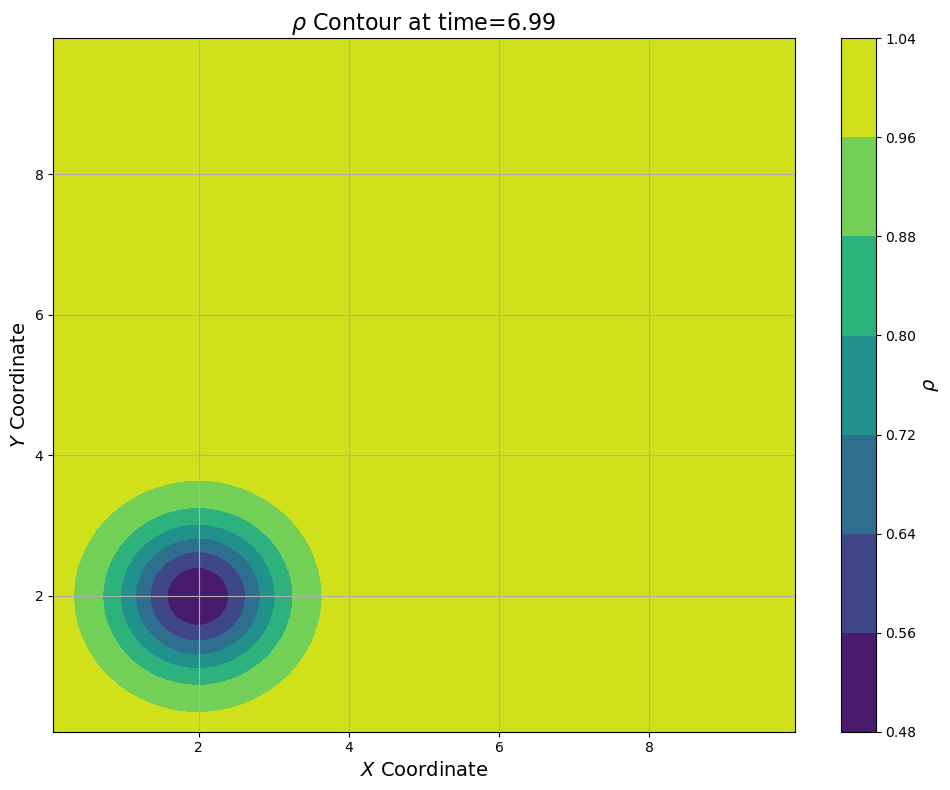

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x and y are already defined
# Calculate xc and yc using numpy for better performance
xc = 0.5 * (x[:-1] + x[1:])
yc = 0.5 * (y[:-1] + y[1:])

# Create a meshgrid for contour plot
X, Y = np.meshgrid(xc, yc)

# Prepare the 2D field value
field_value_2d = field_value[:, :, 0]

# Plot configuration
plt.figure(figsize=(10, 8))  # Adjusted figsize for better visualization
contour = plt.contourf(X,Y, field_value_2d, cmap='viridis')

# Add color bar
cbar = plt.colorbar(contour)
cbar.set_label(r'$\rho$', fontsize=14)

# Add labels and title with LaTeX-like syntax
plt.xlabel(r'$X$ Coordinate', fontsize=14)
plt.ylabel(r'$Y$ Coordinate', fontsize=14)
plt.title(r'$\rho$ Contour at time=%.2f' % time, fontsize=16)

# Add grid for better readability
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure if needed
# plt.savefig('rho_contour.png', dpi=300)


Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0000.vtk
Field shape: (80, 80), Time: 0.0
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0000.vtk
Field shape: (80, 80), Time: 0.0
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0001.vtk
Field shape: (80, 80), Time: 0.9910116
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0002.vtk
Field shape: (80, 80), Time: 1.999142
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0003.vtk
Field shape: (80, 80), Time: 2.990246
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0004.vtk
Field shape: (80, 80), Time: 3.998489
Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vort

Processing file: /home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out/data.0000.vtk
Field shape: (80, 80), Time: 0.0


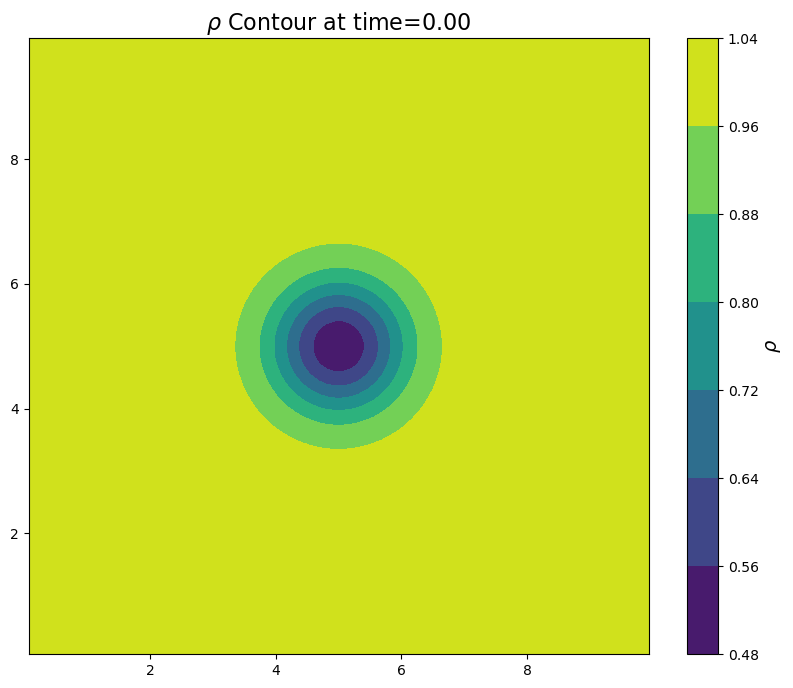

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

run_folder = "/home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out"
data_file_pattern = "data.{:04d}.vtk"

nmin = 0
nmax = 100

# Get coordinates (assuming they are the same for all files)
first_data_file_path = os.path.join(run_folder, data_file_pattern.format(nmin))
x = get_XCoordinate_pluto(first_data_file_path)
y = get_YCoordinate_pluto(first_data_file_path)

# Calculate xc and yc using numpy for better performance
xc = 0.5 * (x[:-1] + x[1:])
yc = 0.5 * (y[:-1] + y[1:])
X, Y = np.meshgrid(xc, yc)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Get the initial field value to determine contour levels
initial_field_value = get_FieldValue(first_data_file_path, "rho")[:, :, 0]
vmin = initial_field_value.min()
vmax = initial_field_value.max()

# Initial plot setup
contour = ax.contourf(X, Y, initial_field_value, cmap='viridis')
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r'$\rho$', fontsize=14)

def update(frame):
    data_file_path = os.path.join(run_folder, data_file_pattern.format(frame))
    print(f"Processing file: {data_file_path}")  # Debug print
    
    field_value = get_FieldValue(data_file_path, "rho")
    field_value_2d = field_value[:, :, 0]
    time, dt = get_time_and_dt_from_file_name(run_folder, data_file_pattern.format(frame))
    
    print(f"Field shape: {field_value_2d.shape}, Time: {time}")  # Debug print   
    # Update contour plot
    contour = ax.contourf(X, Y, field_value_2d, cmap='viridis')
    # Update the title
    ax.set_title(r'$\rho$ Contour at time=%.2f' % time, fontsize=16)

# Create the animation and assign it to a variable
anim = FuncAnimation(fig, update, frames=range(nmin, nmax + 1), repeat=False)

# Display the animation in the notebook
HTML(anim.to_html5_video())

# Save the animation if needed
# ani.save('rho_contour_animation.mp4', writer='ffmpeg', dpi=300)

In [5]:
import numpy as np
#keeping divyansh'r original style for exact solution

# Define the function to calculate the exact solution
def exact_solution_isentropic_vortex(time, x_pos, y_pos):
    # Constants
    gamma = 1.4  
    x0, y0 = 5.0, 5.0  
    epsilon = 5.0 
    rho_inf = 1.0  
    u_inf = 1.0  
    v_inf = 1.0  
    p_inf = 1.0  

    # Calculate vortex center position at the given time
    x_t = x0 + u_inf * time
    y_t = y0 + v_inf * time
    
    # Calculate squared distance from vortex center
    r2 = (x_pos - x_t)**2 + (y_pos - y_t)**2
    
    # Calculate velocity components
    u = u_inf - ((epsilon * (y_pos - y_t) * np.exp((1-r2)/2)) / (2 * np.pi))
    v = v_inf + ((epsilon * (x_pos - x_t) * np.exp((1-r2)/2)) / (2 * np.pi))
    # Create the w field full of zeros with the same shape as u
    w = 0.0
    
    # Calculate density
    rho = (1 - ((gamma - 1) * epsilon**2) / (8 * gamma * np.pi**2) * np.exp(1 - r2))**(1 / (gamma - 1))
    
    # Calculate pressure
    p = (rho / rho_inf)**gamma * p_inf
    
    # Return the calculated properties
    return {
        'rho': rho,
        'vx1': u,
        'vx2': v,
        'vx3': w,
        'prs': p
    }

# Example usage
time = 0.1
x_pos = 6.0
y_pos = 6.0
solution = exact_solution_isentropic_vortex(time, x_pos, y_pos)
print(solution)


{'rho': 0.882741029979479, 'vx1': 0.47470731139539735, 'vx2': 1.5252926886046025, 'vx3': 0.0, 'prs': 0.8397821483812712}


In [7]:
# Load the numerical solution
run_folder = "/home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/2D_HD_Isentropic_Vortex_FD/out"
data_file_name = "data.0000.vtk"
data_file_path = os.path.join(run_folder, data_file_name)

# Get coordinates and field data
xi = get_XCoordinate_pluto(data_file_path)
yi = get_YCoordinate_pluto(data_file_path)
z = get_ZCoordinate_pluto(data_file_path)
field_names = get_FieldNames_pluto(data_file_path)
field_value = get_FieldValue(data_file_path, "rho")

x = 0.5 * (xi[:-1] + xi[1:])
y = 0.5 * (yi[:-1] + yi[1:])

time, dt = get_time_and_dt_from_file_name(run_folder, data_file_name)

# Prepare the exact solution array
exact_rho = np.zeros_like(field_value[:, :, 0])
differences =0.0
n_points = 0
l1_norm = 0.0
l2_norm = 0.0
# Calculate the exact solution at each grid point
for i in range(len(xi) - 1):
    for j in range(len(yi) - 1):
        sol = exact_solution_isentropic_vortex(time, x[i], y[j])
        exact_rho[i, j] = sol['rho']
        differences = differences + np.abs(field_value[i, j, 0] - exact_rho[i, j])
        n_points = n_points+1
        l1_norm = l1_norm + np.abs(field_value[i, j, 0] - exact_rho[i, j])
        l2_norm = l1_norm + (field_value[i, j, 0] - exact_rho[i, j])**2

# Calculate the differences
#differences = np.abs(field_value[:, :, 0] - exact_rho)

# Number of grid points
N = n_points

# Calculate L1 norm
l1_norm = l1_norm / N

# Calculate L2 norm
l2_norm = np.sqrt(l2_norm / N)


print(f"N-points:{N}")
print(f"L1 norm: {l1_norm}")
print(f"L2 norm: {l2_norm}")


print(f"Grid: {np.size(x)} x {np.size(y)}")

N-points:6400
L1 norm: 8.82693548993202e-09
L2 norm: 9.395177214897025e-05
Grid: 80 x 80
